In [3]:
from sklearn.datasets import fetch_california_housing

data = fetch_california_housing()
print(data.feature_names)

['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


In [4]:
X, y = data.data, data.target

Let’s try the traditional design of a neural network, namely, the pyramid structure. A pyramid structure is to have the number of neurons in each layer decreasing as the network progresses to the output. The number of input features is fixed, but you set a large number of neurons on the first hidden layer and gradually reduce the number in the subsequent layers. Because you have only one target in this dataset, the final layer should output only one value.

In [5]:
import torch.nn as nn

#Define the model
model = nn.Sequential(
    nn.Linear(8, 24),
    nn.ReLU(),
    nn.Linear(24, 12),
    nn.ReLU(),
    nn.Linear(12, 6),
    nn.ReLU(),
    nn.Linear(6, 1)
)

To train this network, you need to define a loss function. MSE is a reasonable choice. You also need an optimizer, such as Adam.

In [6]:
import torch.optim as optim

# loss function and optimzer
loss_fn = nn.MSELoss() #mean square error
optimizer = optim.Adam(model.parameters(), lr=0.0001)

To train this model, you can use your usual training loop. In order to obtain an evaluation score so you are confident that the model works, you need to split the data into training and test sets. You may also want to avoid overfitting by keeping track on the test set MSE. The following is the training loop with the train-test split:

In [19]:
import copy
import numpy as np
import torch
import tqdm
from sklearn.model_selection import train_test_split

# train-test split of the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)

# training parameters
n_epochs = 100   # number of epochs to run
batch_size = 10  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)

# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []

# training loop
for epoch in range(n_epochs):
    model.train()
    with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())

# restore model and return best accuracy
model.load_state_dict(best_weights)

<All keys matched successfully>

In the training loop, tqdm is used to set up a progress bar and in each iteration step, MSE is calculated and reported. You can see how the MSE changed by setting the tqdm parameter disable above to False.

Note that in the training loop, each epoch is to run the forward and backward steps with the training set a few times to optimize the model weights, and at the end of the epoch, the model is evaluated using the test set. It is the MSE from the test set that is remembered in the list history. It is also the metric to evaluate a model, which the best one is stored in the variable best_weights.

After you run this, you will have the best model restored and the best MSE stored in the variable best_mse. Note that the mean square error is the average of the square of the difference between the predicted value and the actual value. The square root of it, RMSE, can be regarded as the average difference and it is numerically more useful.

In below, you can show the MSE and RMSE, and plot the history of MSE. It should be decreasing with the epochs.

MSE : 0.47
RMSE : 0.69


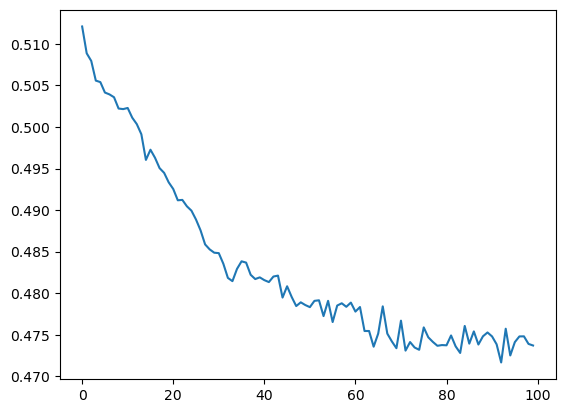

In [20]:
import matplotlib.pyplot as plt

print("MSE : %.2f" % best_mse)
print("RMSE : %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()